In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import locale
import calendar
import math
locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

# Lectura de datos

In [2]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../../data/data_boyaca_final.nc')
df_boyaca = data_boyaca.to_dataframe().reset_index(drop=True)

# Leer el shapefile con los municipios de Boyacá
gdf_boyaca = gpd.read_file('../../shapes/MGN_MPIO_POLITICO.shp')
# Seleccionar solo BOYACÁ
gdf_boyaca = gdf_boyaca[gdf_boyaca['DPTO_CNMBR'] == 'BOYACÁ']
# Dejar solo las columnas geometry y MPIO_CNMBR
gdf_boyaca = gdf_boyaca[['geometry', 'MPIO_CNMBR']]
# Renoimbrar la columna MPIO_CNMBR a municipio
gdf_boyaca.rename(columns={'MPIO_CNMBR': 'municipality'}, inplace=True)
# Capitalizar los nombres de los municipios
gdf_boyaca['municipality'] = gdf_boyaca['municipality'].str.title()
df_boyaca['municipality'] = df_boyaca['municipality'].str.title()

In [3]:
df_boyaca['time'] = pd.to_datetime(df_boyaca['time'])
df_boyaca['year'] = df_boyaca['time'].dt.year.astype(str)
df_boyaca['month'] = df_boyaca['time'].dt.month.apply(lambda x: calendar.month_name[x]).str.capitalize()

In [3]:

data = df_boyaca.copy()  # Asegurar que estamos trabajando con una copia
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
# eliminar los datos del mes del mes 5 del año 2023
# data = data[~((data['year'] == 2023) & (data['month'] == 5))]

# Preprocesamiento de datos
data = data[['latitude', 'longitude', 'year', 'month', 'precip', 'municipality']]
data = data.dropna()

data.sample(5)

,latitude,longitude,year,month,precip,municipality
5082992,5.674999,-73.925003,1986,4,6.961528,Briceño
201039,4.824997,-73.175003,2022,6,0.000000,San Luis De Gaceno
8687153,6.024998,-73.525002,2014,5,0.000000,San José De Pare
6139449,5.724998,-72.575005,1994,9,0.000000,Pisba
10703951,6.625000,-72.225006,2022,7,10.890183,Güicán


# RNNs - LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



# Agregación mensual de precipitación
monthly_data = data.groupby(['latitude', 'longitude', 'year', 'month']).agg({'precip': 'sum'}).reset_index()


# Dividir datos en características y etiquetas
X = monthly_data[['latitude', 'longitude', 'year', 'month']].values
y = monthly_data['precip'].values


# Escalar características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el modelo RNN con LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Hacer predicciones
sample_input = np.array([[6.0249977112, -74.5250015259, 2023, 6]])  # Ejemplo de entrada (latitud, longitud, año, mes)
sample_input_scaled = scaler_X.transform(sample_input)
sample_input_reshaped = sample_input_scaled.reshape(1, -1, 1)  
prediction = model.predict(sample_input_reshaped)
print(f'Predicción de precipitación: {prediction[0][0]}')





In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



# Agregación mensual de precipitación
monthly_data = data.groupby(['latitude', 'longitude', 'year', 'month']).agg({'precip': 'sum'}).reset_index()


# Dividir datos en características y etiquetas
X = monthly_data[['latitude', 'longitude', 'year', 'month']].values
y = monthly_data['precip'].values


# Escalar características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el modelo RNN con LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stopping])


# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Crear una lista para almacenar las predicciones
predictions = []

# Hacer predicciones para todos los puntos únicos
unique_points = data[['latitude', 'longitude', 'municipality']].drop_duplicates()
for index, point in unique_points.iterrows():
    for month_offset in range(0, 12):  # Predicciones para los siguientes 12 meses a partir de junio de 2023
        year = 2023 if month_offset < 7 else 2024
        month = (6 + month_offset) % 12
        if month == 0:
            month = 12
        prediction_input = np.array([[point['latitude'], point['longitude'], year, month]])
        prediction_input_scaled = scaler_X.transform(prediction_input)
        prediction_input_reshaped = prediction_input_scaled.reshape(1, -1, 1)
        prediction = model.predict(prediction_input_reshaped)
        predictions.append({'latitude': point['latitude'],
                            'longitude': point['longitude'],
                            'municipality': point['municipality'],
                            'year': year,
                            'month': month,
                            'prediction': prediction[0][0]})

# Crear un DataFrame a partir de la lista de predicciones
prediction_data = pd.DataFrame(predictions)

# Guardar el DataFrame de predicciones en un archivo CSV
prediction_data.to_csv('predictions_RNNs_LSTM.csv', index=False)





Epoch 1/100
9582/9582 [==============================] - 42s 4ms/step - loss: 5819.4170 - val_loss: 3927.0178
Epoch 2/100
9582/9582 [==============================] - 43s 4ms/step - loss: 3829.4451 - val_loss: 3582.3647
Epoch 3/100
9582/9582 [==============================] - 46s 5ms/step - loss: 3520.9407 - val_loss: 3385.0784
Epoch 4/100
9582/9582 [==============================] - 44s 5ms/step - loss: 3308.2476 - val_loss: 3180.1013
Epoch 5/100
9582/9582 [==============================] - 43s 5ms/step - loss: 2989.9534 - val_loss: 2579.3730
Epoch 6/100
9582/9582 [==============================] - 43s 4ms/step - loss: 2423.7134 - val_loss: 2235.8279
Epoch 7/100
9582/9582 [==============================] - 44s 5ms/step - loss: 2290.2119 - val_loss: 2180.5574
Epoch 8/100
9582/9582 [==============================] - 51s 5ms/step - loss: 2228.5881 - val_loss: 2155.0959
Epoch 9/100
9582/9582 [==============================] - 49s 5ms/step - loss: 2184.4702 - val_loss: 2179.7871
Epoch 10/1

In [5]:
# Calcular las predicciones del modelo
y_pred_lstm = model.predict(X_test_reshaped)

# Importar las funciones necesarias de scikit-learn para calcular las métricas
from sklearn.metrics import mean_squared_error, r2_score

# Calcular el Error Cuadrático Medio (MSE)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse_lstm = np.sqrt(mse_lstm)

# Calcular el Coeficiente de Determinación (R^2)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f'MSE del modelo LSTM: {mse_lstm}')
print(f'RMSE del modelo LSTM: {rmse_lstm}')
print(f'R^2 del modelo LSTM: {r2_lstm}')


2396/2396 [==============================] - 8s 4ms/step
MSE del modelo LSTM: 1401.3756103515625
RMSE del modelo LSTM: 37.43495178222656
R^2 del modelo LSTM: 0.876476450146648


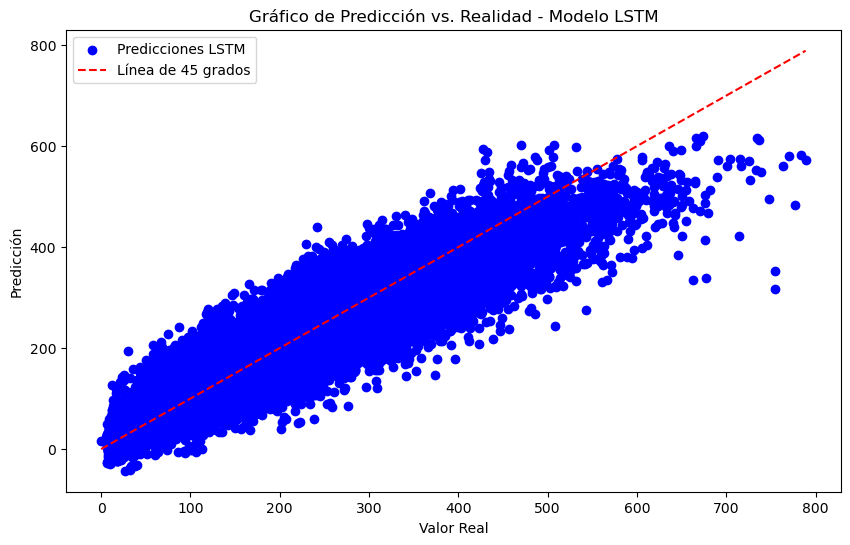

In [6]:
import matplotlib.pyplot as plt

# Gráfico de Predicción vs. Realidad para el modelo LSTM
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lstm, color='blue', label='Predicciones LSTM')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de 45 grados')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Gráfico de Predicción vs. Realidad - Modelo LSTM')
plt.legend()
plt.show()




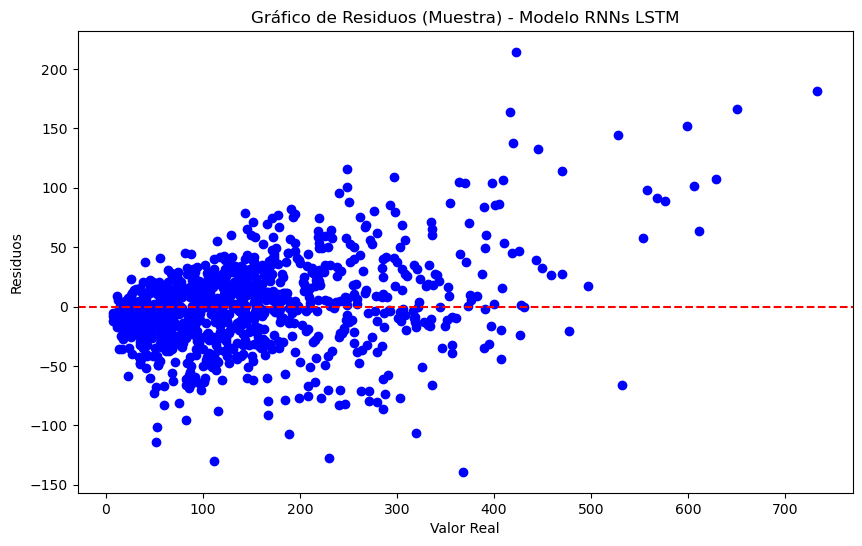

In [16]:
import random

# Elegir una muestra aleatoria de índices
sample_indices = random.sample(range(len(y_test)), k=1000)  # Cambia el valor de 'k' según lo necesites

# Crear una lista para almacenar los residuos de la muestra
sample_residues_lstm = [y_test[i] - y_pred_lstm[i] for i in sample_indices]

# Gráfico de Residuos para el modelo LSTM
plt.figure(figsize=(10, 6))
plt.scatter(y_test[sample_indices], sample_residues_lstm, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos (Muestra) - Modelo RNNs LSTM')
plt.show()

